In [41]:
# this notebook is for investigating the value function

import torch as th
import gymnasium as gym
import glob
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sys.path.append('../src/')
from model import AlphaZeroModel
from environment import investigate_model

In [42]:


env_id = "CliffWalking-v0"
checkpoint_path = f"../runs/{env_id}*"
env = gym.make(env_id, render_mode="rgb_array")

if "*" in checkpoint_path:
    matches = glob.glob(checkpoint_path)
    dir = max(matches)
    checkpoint_path = os.path.join(dir, "checkpoint.pth")
checkpoint_path

'../runs/CliffWalking-v0_20231213-192333/checkpoint.pth'

In [43]:

model = AlphaZeroModel.load_model(checkpoint_path, env)
model

AlphaZeroModel(
  (layers): ModuleList(
    (0): Linear(in_features=48, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=256, bias=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU()
  )
  (value_head): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
  (policy_head): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [44]:
assert isinstance(env.observation_space, gym.spaces.Discrete)
outputs = investigate_model(env.observation_space, model)
outputs

{0: (tensor(-357.2764), tensor([0.4118, 0.3528, 0.1198, 0.1156])),
 1: (tensor(-355.5970), tensor([0.4112, 0.3524, 0.1203, 0.1161])),
 2: (tensor(-354.5094), tensor([0.4109, 0.3521, 0.1206, 0.1164])),
 3: (tensor(-351.9924), tensor([0.4101, 0.3515, 0.1213, 0.1171])),
 4: (tensor(-350.1842), tensor([0.4095, 0.3510, 0.1218, 0.1177])),
 5: (tensor(-350.0427), tensor([0.4094, 0.3510, 0.1219, 0.1177])),
 6: (tensor(-347.6980), tensor([0.4087, 0.3504, 0.1225, 0.1184])),
 7: (tensor(-344.7917), tensor([0.4078, 0.3496, 0.1233, 0.1193])),
 8: (tensor(-343.7155), tensor([0.4074, 0.3493, 0.1237, 0.1196])),
 9: (tensor(-335.7817), tensor([0.4049, 0.3472, 0.1259, 0.1219])),
 10: (tensor(-331.2110), tensor([0.4034, 0.3460, 0.1273, 0.1233])),
 11: (tensor(-329.7882), tensor([0.4030, 0.3456, 0.1277, 0.1237])),
 12: (tensor(-361.2591), tensor([0.4130, 0.3538, 0.1187, 0.1145])),
 13: (tensor(-361.5052), tensor([0.4131, 0.3539, 0.1186, 0.1144])),
 14: (tensor(-356.1540), tensor([0.4114, 0.3525, 0.1201, 0

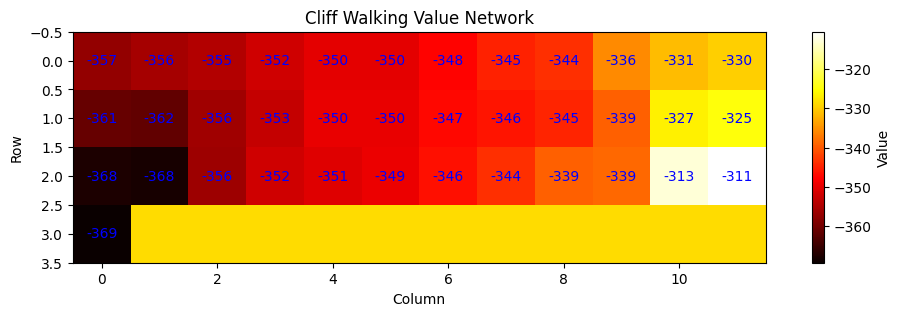

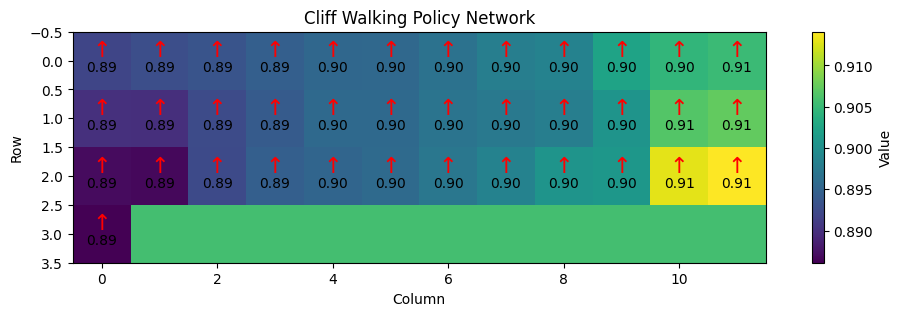

In [45]:
# lets interpret the outputs based on the cliff walking environment
"""
Observation Space
There are 3 x 12 + 1 possible states. The player cannot be at the cliff, nor at the goal as the latter results in the end of the episode. What remains are all the positions of the first 3 rows plus the bottom-left cell.

The observation is a value representing the player’s current position as current_row * nrows + current_col (where both the row and col start at 0).

For example, the stating position can be calculated as follows: 3 * 12 + 0 = 36.

The observation is returned as an int().

The action shape is (1,) in the range {0, 3} indicating which direction to move the player.

0: Move up

1: Move right

2: Move down

3: Move left
"""




# Define the dimensions of the grid
nrows, ncols = 4, 12

# Initialize a grid with zeros
grid = np.zeros((nrows, ncols))

# Populate the grid with values from the dictionary
for state, value in outputs.items():
    row, col = divmod(state, ncols)
    grid[row, col] = value[0]

# Plotting
plt.figure(figsize=(12, 3))
plt.imshow(grid, cmap='hot', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Cliff Walking Value Network')
plt.xlabel('Column')
plt.ylabel('Row')
plt.grid(False)
for i in range(nrows):
    for j in range(ncols):
        if i < 3 or j < 1:
            plt.text(j, i, f'{grid[i, j]:.0f}', ha='center', va='center', color='blue')

plt.show()


#do the same for the policy

action_arrows = {0: '↑', 1: '→', 2: '↓', 3: '←'}

preffered_actions = np.zeros((nrows, ncols), dtype='<U2')
entropy = np.zeros((nrows, ncols))

for state, action in outputs.items():
    row, col = divmod(state, ncols)
    preffered_actions[row, col] = action_arrows[np.argmax(action[1]).item()]
    entropy[row, col] = th.distributions.Categorical(probs=action[1]).entropy().item() / np.log(4)


plt.figure(figsize=(12, 3))
plt.imshow(entropy, interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Cliff Walking Policy Network')
plt.xlabel('Column')
plt.ylabel('Row')
plt.grid(False)
for i in range(nrows):
    for j in range(ncols):
        if i < 3 or j < 1:
            plt.text(j, i, f'{entropy[i, j]:.2f}', ha='center', va='top', color='black')
            plt.text(j, i, f'{preffered_actions[i, j]}', ha='center', va='bottom', color='red', fontsize=16)

plt.show()